In [78]:
import pandas as pd

In [79]:
# intraloop

shap_values = {}

for x in [6,7,8,9,10,11]:
    df = pd.read_csv(f"/home/ec2-user/ML-correlator/Tree_classifier_for_graphs/new_stuff/results/bayes_shap_result/loop{x}/motifs_eig_centrality_/loop{x}_motifs_eig_centrality_shap_sample.csv")
    shap_values[x] = df


In [80]:
shap_values[9].shape

(10000, 99)

In [81]:
shap_values.keys()

dict_keys([6, 7, 8, 9, 10, 11])

In [82]:
for x,y in shap_values.items():
    print(y.shape)

(31, 99)
(164, 99)
(1432, 99)
(10000, 99)
(10000, 99)
(10000, 99)


In [83]:
columns = shap_values[6].columns

In [84]:
len(columns)

99

In [85]:
lap_features = [x for x in columns if 'lap' in x.lower()]
centrality_features = [x for x in columns if 'centrality' in x.lower()]
motifs5 = [x for x in columns if 'motif_5' in x.lower() or 'motif_induced5' in x.lower() or '5set' in x.lower()]
motifs4 = [x for x in columns if 'motif_4' in x.lower() or 'motif_induced4' in x.lower() or '4set' in x.lower() or 'square' in x.lower()\
           or ('_4' in x.lower() and 'lap' not in x.lower() and 'induced5' not in x.lower())]

motifs3 = [x for x in columns if 'triangle' in x.lower() or 'wedge' in x.lower()]

len(lap_features) + len(centrality_features) + len(motifs5) + len(motifs4) + len(motifs3)

98

In [86]:
len(set(lap_features).union(set(centrality_features)).union(set(motifs5)).union(set(motifs4)).union(set(motifs3)))

98

In [87]:
shap_values[6][lap_features].mean().mean()

np.float64(0.0016578028901483872)

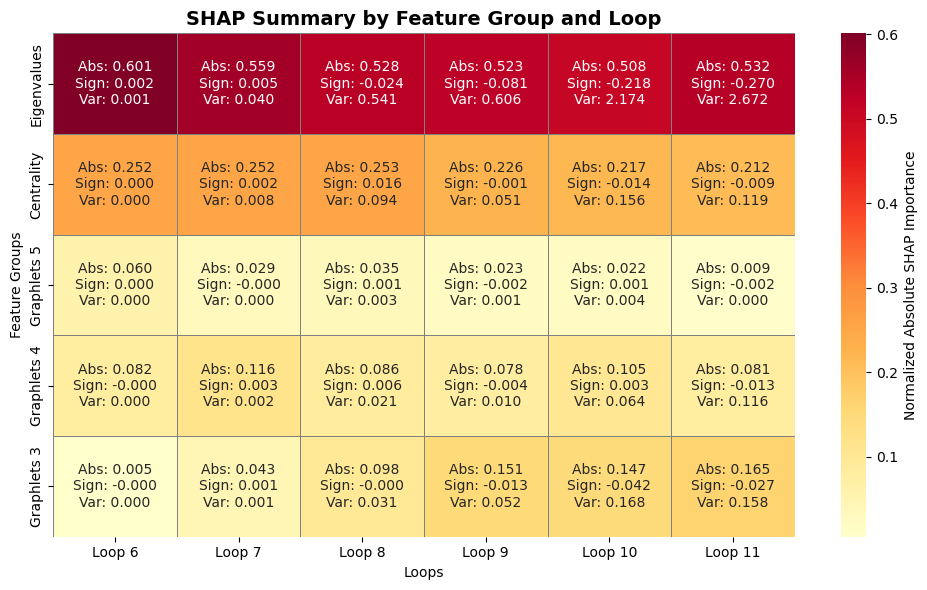

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Feature Groups
# -----------------------------
feature_groups = {
    'Eigenvalues': lap_features,
    'Centrality': centrality_features,
    'Graphlets 5': motifs5,
    'Graphlets 4': motifs4,
    'Graphlets 3': motifs3
}

loops = sorted(shap_values.keys())

# =====================================================
# 1️⃣ ABSOLUTE SHAP (IMPORTANCE)
# =====================================================
heatmap_data_abs = []

for group_name, group_features in feature_groups.items():
    row = []
    for loop in loops:

        available_features = [f for f in group_features if f in shap_values[loop].columns]

        if available_features:
            group_shap = shap_values[loop][available_features]
            value = np.abs(group_shap).mean().mean()
        else:
            value = 0.0

        row.append(value)

    heatmap_data_abs.append(row)

heatmap_abs = pd.DataFrame(
    heatmap_data_abs,
    index=feature_groups.keys(),
    columns=[f'Loop {loop}' for loop in loops]
)

# ✅ Correct normalization → proportion per loop
heatmap_abs_norm = heatmap_abs.div(heatmap_abs.sum(axis=0), axis=1)


# =====================================================
# 2️⃣ SIGNED SHAP (DIRECTION)
# =====================================================
heatmap_data_signed = []

for group_name, group_features in feature_groups.items():
    row = []
    for loop in loops:

        available_features = [f for f in group_features if f in shap_values[loop].columns]

        if available_features:
            group_shap = shap_values[loop][available_features]
            value = group_shap.mean().mean()
        else:
            value = 0.0

        row.append(value)

    heatmap_data_signed.append(row)

heatmap_signed = pd.DataFrame(
    heatmap_data_signed,
    index=feature_groups.keys(),
    columns=[f'Loop {loop}' for loop in loops]
)


# =====================================================
# 3️⃣ VARIANCE (STABILITY / INTERACTIONS)
# =====================================================
heatmap_data_var = []

for group_name, group_features in feature_groups.items():
    row = []
    for loop in loops:

        available_features = [f for f in group_features if f in shap_values[loop].columns]

        if available_features:
            group_shap = shap_values[loop][available_features]
            value = group_shap.var().mean()
        else:
            value = 0.0

        row.append(value)

    heatmap_data_var.append(row)

heatmap_var = pd.DataFrame(
    heatmap_data_var,
    index=feature_groups.keys(),
    columns=[f'Loop {loop}' for loop in loops]
)


# =====================================================
# 4️⃣ BUILD MULTI-LINE ANNOTATIONS
# =====================================================
annot = heatmap_abs_norm.copy().astype(str)

for row in heatmap_abs_norm.index:
    for col in heatmap_abs_norm.columns:

        abs_val = heatmap_abs_norm.loc[row, col]
        signed_val = heatmap_signed.loc[row, col]
        var_val = heatmap_var.loc[row, col]

        annot.loc[row, col] = (
            f"Abs: {abs_val:.3f}\n"
            f"Sign: {signed_val:.3f}\n"
            f"Var: {var_val:.3f}"
        )


# =====================================================
# 5️⃣ COMBINED HEATMAP (PUBLICATION STYLE)
# =====================================================
plt.figure(figsize=(10, 6))

sns.heatmap(
    heatmap_abs_norm,          # ✅ Color = Importance
    annot=annot,
    fmt="",
    cmap='YlOrRd',
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Normalized Absolute SHAP Importance'}
)

plt.title(
    'SHAP Summary by Feature Group and Loop',
    fontsize=14,
    fontweight='bold'
)

plt.ylabel('Feature Groups')
plt.xlabel('Loops')



plt.tight_layout()
plt.savefig('/home/ec2-user/ML-correlator/Tree_classifier_for_graphs/new_stuff/process/artifacts/intraloop_feature_group_global.png')
plt.show()

In [89]:
# Check what eigenvalue features are available
print("Laplacian features (likely containing eigenvalues):")
print(lap_features)
print(f"\nTotal laplacian features: {len(lap_features)}")

# Look for eigenvalue-specific features (e.g., eig, eigenvalue, lambda)
eigenvalue_features = [x for x in columns if 'eig' in x.lower() or 'eigenvalue' in x.lower() or 'lambda' in x.lower()]
print(f"\nEigenvalue-specific features: {len(eigenvalue_features)}")
if eigenvalue_features:
    print(eigenvalue_features[:10])  # Show first 10


Laplacian features (likely containing eigenvalues):
['Spectral_lap_eig_0', 'Spectral_lap_eig_1', 'Spectral_lap_eig_2', 'Spectral_lap_eig_3', 'Spectral_lap_eig_4', 'Spectral_lap_eig_5', 'Spectral_lap_eig_6', 'Spectral_lap_eig_7', 'Spectral_lap_eig_8', 'Spectral_lap_eig_9']

Total laplacian features: 10

Eigenvalue-specific features: 14
['Spectral_lap_eig_0', 'Spectral_lap_eig_1', 'Spectral_lap_eig_2', 'Spectral_lap_eig_3', 'Spectral_lap_eig_4', 'Spectral_lap_eig_5', 'Spectral_lap_eig_6', 'Spectral_lap_eig_7', 'Spectral_lap_eig_8', 'Spectral_lap_eig_9']


In [90]:
# Extract individual eigenvalue features
# Assuming eigenvalues are in laplacian features, let's identify them
# They might be named like lap_eig_0, lap_eig_1, etc. or lap_eigenvalue_0, etc.

# Get all eigenvalue features from laplacian features
eigenvalue_features = [x for x in lap_features if 'eig' in x.lower()]

# If no explicit eigenvalue features, check if laplacian features are numbered (e.g., lap_0, lap_1, etc.)
if not eigenvalue_features:
    # Try to find numbered features that might be eigenvalues
    eigenvalue_features = [x for x in lap_features if any(char.isdigit() for char in x)]

print(f"Found {len(eigenvalue_features)} eigenvalue features")
if eigenvalue_features:
    print("Sample eigenvalue features:")
    print(eigenvalue_features[:10])
    
# Sort eigenvalue features by their index/number if possible
def extract_eigenvalue_index(feature_name):
    """Extract numeric index from eigenvalue feature name"""
    import re
    # Try to find numbers in the feature name
    numbers = re.findall(r'\d+', feature_name)
    if numbers:
        return int(numbers[-1])  # Use last number found
    return 0

# Sort by index
eigenvalue_features_sorted = sorted(eigenvalue_features, key=extract_eigenvalue_index)

print(f"\nSorted eigenvalue features (first 10):")
print(eigenvalue_features_sorted[:10])


Found 10 eigenvalue features
Sample eigenvalue features:
['Spectral_lap_eig_0', 'Spectral_lap_eig_1', 'Spectral_lap_eig_2', 'Spectral_lap_eig_3', 'Spectral_lap_eig_4', 'Spectral_lap_eig_5', 'Spectral_lap_eig_6', 'Spectral_lap_eig_7', 'Spectral_lap_eig_8', 'Spectral_lap_eig_9']

Sorted eigenvalue features (first 10):
['Spectral_lap_eig_0', 'Spectral_lap_eig_1', 'Spectral_lap_eig_2', 'Spectral_lap_eig_3', 'Spectral_lap_eig_4', 'Spectral_lap_eig_5', 'Spectral_lap_eig_6', 'Spectral_lap_eig_7', 'Spectral_lap_eig_8', 'Spectral_lap_eig_9']


In [91]:
# Calculate mean absolute SHAP importance for each eigenvalue and loop
eigenvalue_heatmap_data = []

# Get loops in increasing order
loops = sorted(shap_values.keys())

# Use sorted eigenvalue features
for eig_feature in eigenvalue_features_sorted:
    row = []
    for loop in loops:
        # Check if this eigenvalue feature exists in this loop's SHAP data
        if eig_feature in shap_values[loop].columns:
            # Calculate mean absolute SHAP value for this eigenvalue
            eig_shap = shap_values[loop][eig_feature]
            mean_importance = np.abs(eig_shap).mean()
            row.append(mean_importance)
        else:
            row.append(0.0)
    eigenvalue_heatmap_data.append(row)

# Create DataFrame
eigenvalue_heatmap_df = pd.DataFrame(
    eigenvalue_heatmap_data,
    index=eigenvalue_features_sorted,
    columns=[f'Loop {loop}' for loop in loops]
)

print("Eigenvalue heatmap data (first few eigenvalues):")
print(eigenvalue_heatmap_df.head(10))
print(f"\nTotal eigenvalues: {len(eigenvalue_heatmap_df)}")

# Normalize across each loop (column-wise normalization)
eigenvalue_heatmap_df_normalized = eigenvalue_heatmap_df.div(eigenvalue_heatmap_df.max(axis=0), axis=1)

print("\nNormalized eigenvalue heatmap data (first few eigenvalues):")
print(eigenvalue_heatmap_df_normalized.head(10))


Eigenvalue heatmap data (first few eigenvalues):
                      Loop 6    Loop 7    Loop 8    Loop 9   Loop 10   Loop 11
Spectral_lap_eig_0  0.005971  0.029691  0.240004  0.046750  0.094278  0.049735
Spectral_lap_eig_1  0.067406  0.426147  1.523015  1.802043  3.883041  4.137924
Spectral_lap_eig_2  0.037316  0.319669  0.685310  0.347861  0.279688  0.524953
Spectral_lap_eig_3  0.000031  0.049850  0.363972  0.148169  0.181442  0.225362
Spectral_lap_eig_4  0.000000  0.003137  0.242585  0.197439  0.249122  0.163081
Spectral_lap_eig_5  0.000000  0.128466  0.253414  0.071291  0.169294  0.127464
Spectral_lap_eig_6  0.008767  0.092580  0.460055  0.255093  0.315978  0.133814
Spectral_lap_eig_7  0.000000  0.055614  0.219595  0.164837  0.320992  0.211539
Spectral_lap_eig_8  0.000000  0.007504  0.188111  0.137081  0.295628  0.254856
Spectral_lap_eig_9  0.004495  0.007771  0.189096  0.184027  0.229039  0.186262

Total eigenvalues: 10

Normalized eigenvalue heatmap data (first few eigenvalues)

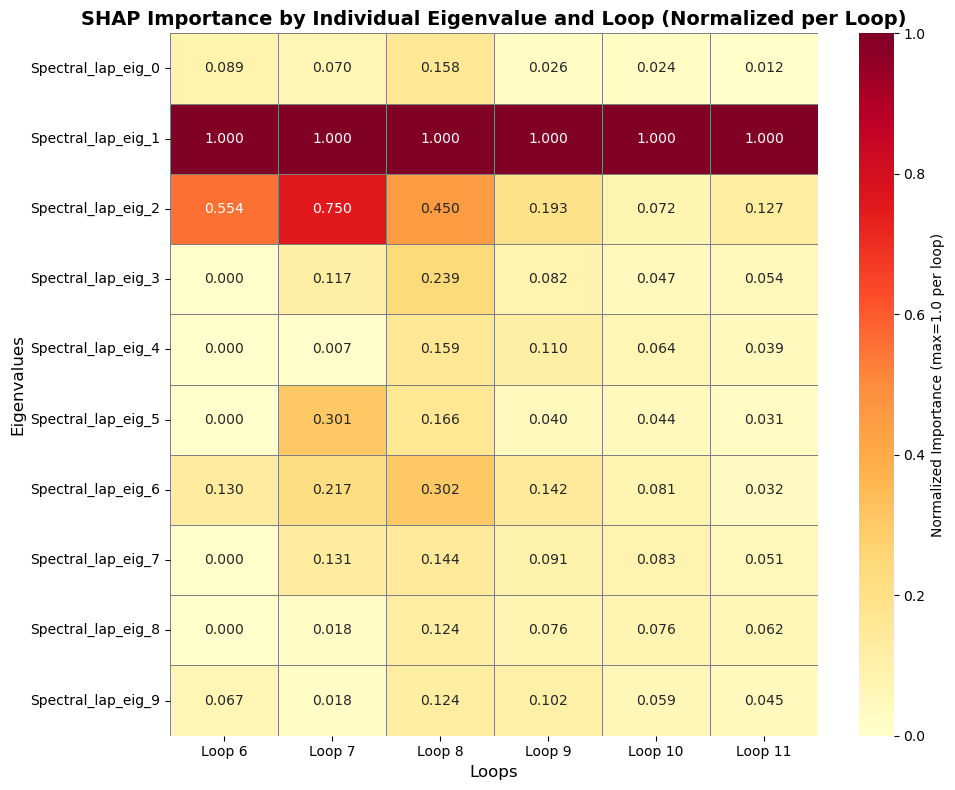

In [92]:
# Create the eigenvalue heatmap
# Adjust figure size based on number of eigenvalues
n_eigenvalues = len(eigenvalue_heatmap_df_normalized)
fig_height = max(8, n_eigenvalues * 0.3)  # Scale height with number of eigenvalues

plt.figure(figsize=(10, fig_height))

# Only show annotations if there aren't too many eigenvalues (to avoid clutter)
show_annotations = n_eigenvalues <= 50

sns.heatmap(
    eigenvalue_heatmap_df_normalized,
    annot=show_annotations,
    fmt='.3f' if show_annotations else '.2f',
    cmap='YlOrRd',
    cbar_kws={'label': 'Normalized Importance (max=1.0 per loop)'},
    linewidths=0.1 if n_eigenvalues > 20 else 0.5,
    linecolor='gray',
    vmin=0,
    vmax=1,
    xticklabels=True,
    yticklabels=True
)

plt.title('SHAP Importance by Individual Eigenvalue and Loop (Normalized per Loop)', 
          fontsize=14, fontweight='bold')
plt.ylabel('Eigenvalues', fontsize=12)
plt.xlabel('Loops', fontsize=12)

# Rotate y-axis labels if there are many eigenvalues
if n_eigenvalues > 20:
    plt.yticks(rotation=0, fontsize=8)
else:
    plt.yticks(rotation=0)

plt.tight_layout()
plt.show()


Text(1.02, 0.5, 'Cell Values:\nAbs  → Normalized Importance\n')

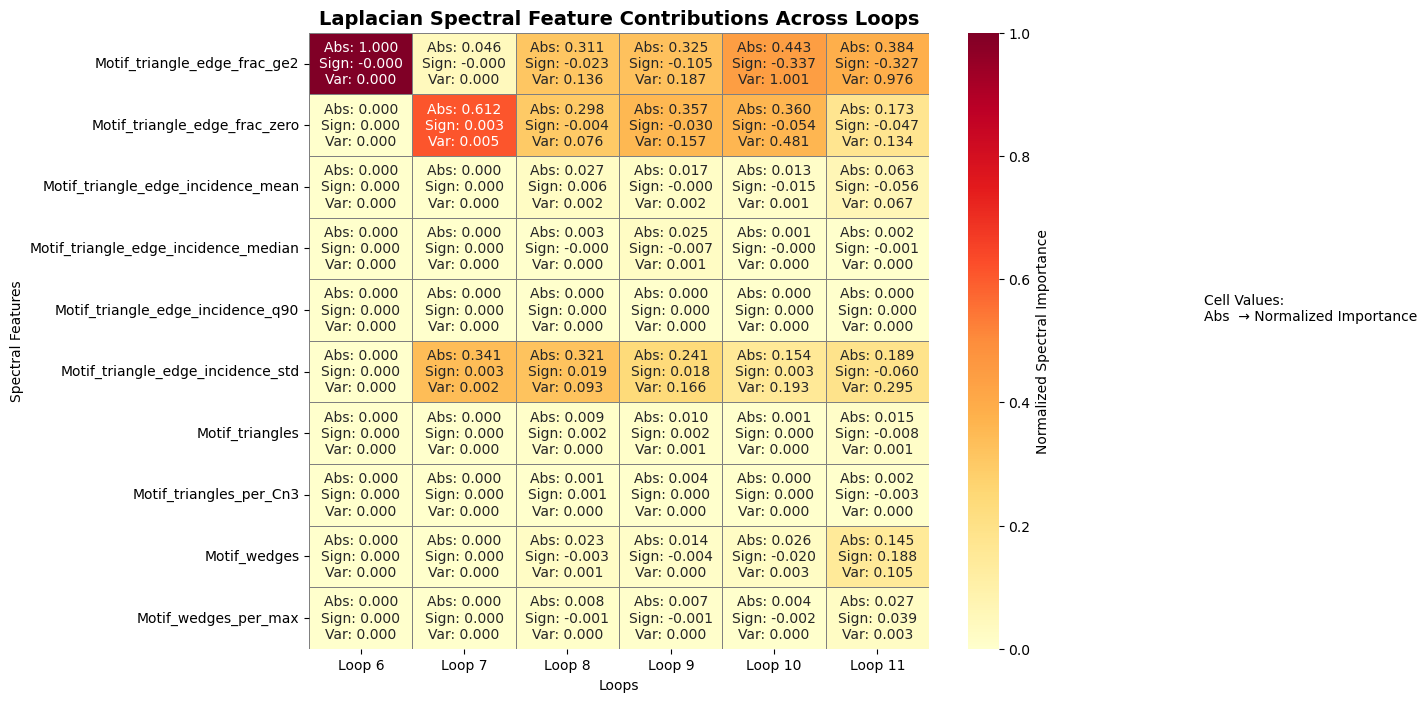

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Laplacian Spectral Features
# -----------------------------
# lap_features = your 10 eigenvalue/spectral variables

loops = sorted(shap_values.keys())

# =====================================================
# 1️⃣ ABSOLUTE SHAP (IMPORTANCE)
# =====================================================
laplacian_abs = []

for feature in motifs3:
    row = []
    for loop in loops:

        if feature in shap_values[loop].columns:
            value = np.abs(shap_values[loop][feature]).mean()
        else:
            value = 0.0

        row.append(value)

    laplacian_abs.append(row)

laplacian_abs_df = pd.DataFrame(
    laplacian_abs,
    index=motifs3,
    columns=[f'Loop {loop}' for loop in loops]
)

# ✅ Normalize importance → proportion per loop
laplacian_abs_norm = laplacian_abs_df.div(
    laplacian_abs_df.sum(axis=0),
    axis=1
)

# =====================================================
# 2️⃣ SIGNED SHAP (DIRECTION)
# =====================================================
laplacian_signed = []

for feature in motifs3:
    row = []
    for loop in loops:

        if feature in shap_values[loop].columns:
            value = shap_values[loop][feature].mean()
        else:
            value = 0.0

        row.append(value)

    laplacian_signed.append(row)

laplacian_signed_df = pd.DataFrame(
    laplacian_signed,
    index=motifs3,
    columns=[f'Loop {loop}' for loop in loops]
)

# =====================================================
# 3️⃣ VARIANCE (STABILITY / INTERACTIONS)
# =====================================================
laplacian_var = []

for feature in motifs3:
    row = []
    for loop in loops:

        if feature in shap_values[loop].columns:
            value = shap_values[loop][feature].var()
        else:
            value = 0.0

        row.append(value)

    laplacian_var.append(row)

laplacian_var_df = pd.DataFrame(
    laplacian_var,
    index=motifs3,
    columns=[f'Loop {loop}' for loop in loops]
)

# =====================================================
# 4️⃣ BUILD MULTI-LINE ANNOTATIONS
# =====================================================
annot_lap = laplacian_abs_norm.copy().astype(str)

for row in laplacian_abs_norm.index:
    for col in laplacian_abs_norm.columns:

        abs_val = laplacian_abs_norm.loc[row, col]
        signed_val = laplacian_signed_df.loc[row, col]
        var_val = laplacian_var_df.loc[row, col]

        annot_lap.loc[row, col] = (
            f"Abs: {abs_val:.3f}\n"
            f"Sign: {signed_val:.3f}\n"
            f"Var: {var_val:.3f}"
        )

# =====================================================
# 5️⃣ COMBINED HEATMAP (PUBLICATION STYLE)
# =====================================================
plt.figure(figsize=(10, 8))

sns.heatmap(
    laplacian_abs_norm,     # ✅ Color = Importance
    annot=annot_lap,
    fmt="",
    cmap='YlOrRd',
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Normalized Spectral Importance'}
)

plt.title(
    'Laplacian Spectral Feature Contributions Across Loops',
    fontsize=14,
    fontweight='bold'   
)

plt.ylabel('Spectral Features')
plt.xlabel('Loops')

# ✅ Annotation legend (reviewer-friendly)
plt.figtext(
    1.02, 0.5,
    "Cell Values:\n"
    "Abs  → Normalized Importance\n"
)

Text(1.02, 0.5, 'Cell Values:\nAbs  → Normalized Importance\n')

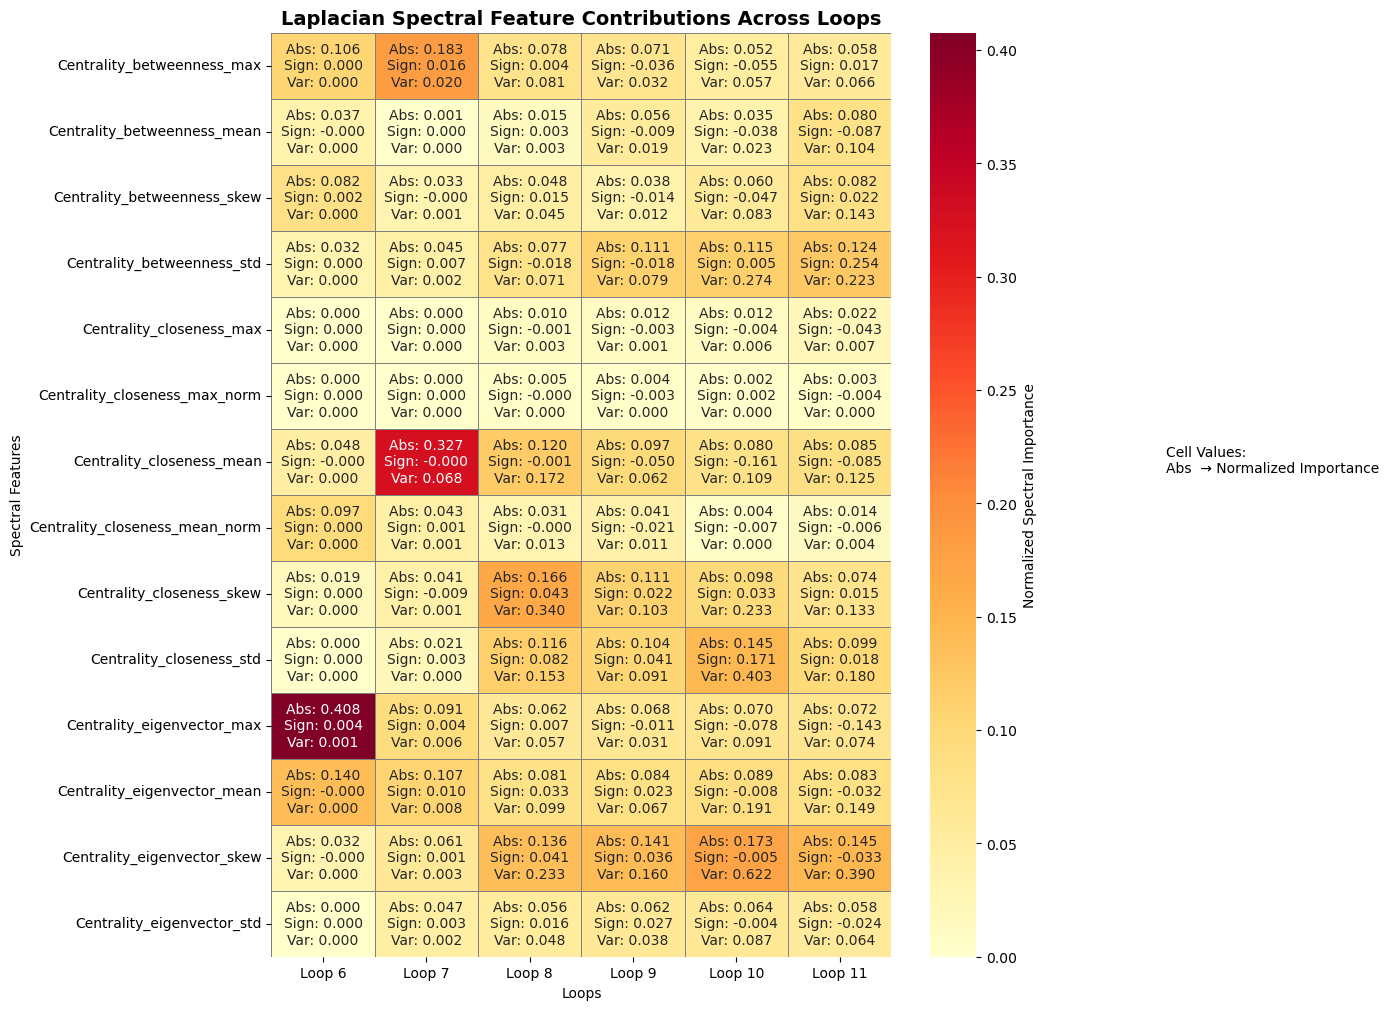

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Laplacian Spectral Features
# -----------------------------
# lap_features = your 10 eigenvalue/spectral variables

loops = sorted(shap_values.keys())

# =====================================================
# 1️⃣ ABSOLUTE SHAP (IMPORTANCE)
# =====================================================
laplacian_abs = []

for feature in centrality_features:
    row = []
    for loop in loops:

        if feature in shap_values[loop].columns:
            value = np.abs(shap_values[loop][feature]).mean()
        else:
            value = 0.0

        row.append(value)

    laplacian_abs.append(row)

laplacian_abs_df = pd.DataFrame(
    laplacian_abs,
    index=centrality_features,
    columns=[f'Loop {loop}' for loop in loops]
)

# ✅ Normalize importance → proportion per loop
laplacian_abs_norm = laplacian_abs_df.div(
    laplacian_abs_df.sum(axis=0),
    axis=1
)

# =====================================================
# 2️⃣ SIGNED SHAP (DIRECTION)
# =====================================================
laplacian_signed = []

for feature in centrality_features:
    row = []
    for loop in loops:

        if feature in shap_values[loop].columns:
            value = shap_values[loop][feature].mean()
        else:
            value = 0.0

        row.append(value)

    laplacian_signed.append(row)

laplacian_signed_df = pd.DataFrame(
    laplacian_signed,
    index=centrality_features,
    columns=[f'Loop {loop}' for loop in loops]
)

# =====================================================
# 3️⃣ VARIANCE (STABILITY / INTERACTIONS)
# =====================================================
laplacian_var = []

for feature in centrality_features:
    row = []
    for loop in loops:

        if feature in shap_values[loop].columns:
            value = shap_values[loop][feature].var()
        else:
            value = 0.0

        row.append(value)

    laplacian_var.append(row)

laplacian_var_df = pd.DataFrame(
    laplacian_var,
    index=centrality_features,
    columns=[f'Loop {loop}' for loop in loops]
)

# =====================================================
# 4️⃣ BUILD MULTI-LINE ANNOTATIONS
# =====================================================
annot_lap = laplacian_abs_norm.copy().astype(str)

for row in laplacian_abs_norm.index:
    for col in laplacian_abs_norm.columns:

        abs_val = laplacian_abs_norm.loc[row, col]
        signed_val = laplacian_signed_df.loc[row, col]
        var_val = laplacian_var_df.loc[row, col]

        annot_lap.loc[row, col] = (
            f"Abs: {abs_val:.3f}\n"
            f"Sign: {signed_val:.3f}\n"
            f"Var: {var_val:.3f}"
        )

# =====================================================
# 5️⃣ COMBINED HEATMAP (PUBLICATION STYLE)
# =====================================================
plt.figure(figsize=(10, 12))

sns.heatmap(
    laplacian_abs_norm,     # ✅ Color = Importance
    annot=annot_lap,
    fmt="",
    cmap='YlOrRd',
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Normalized Spectral Importance'}
)

plt.title(
    'Laplacian Spectral Feature Contributions Across Loops',
    fontsize=14,
    fontweight='bold'   
)

plt.ylabel('Spectral Features')
plt.xlabel('Loops')

# ✅ Annotation legend (reviewer-friendly)
plt.figtext(
    1.02, 0.5,
    "Cell Values:\n"
    "Abs  → Normalized Importance\n"
)

Text(0.5, 102.72222222222219, 'Loops')

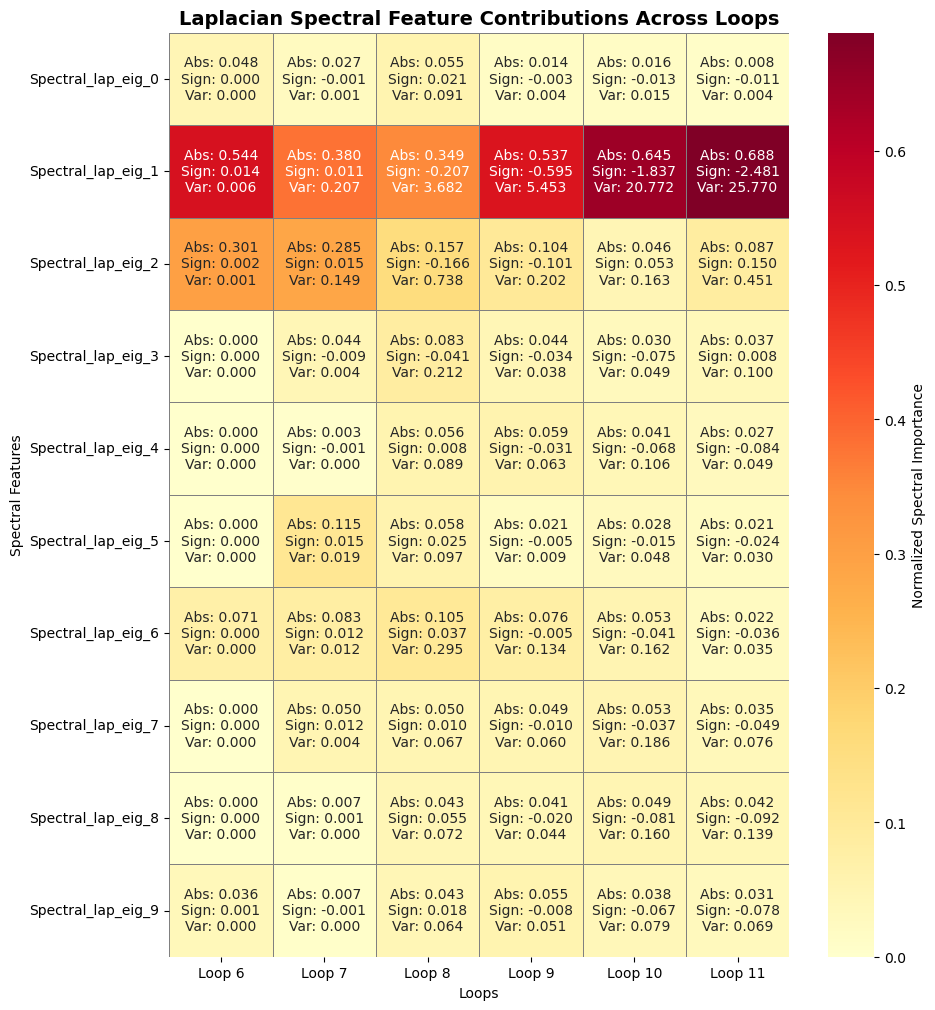

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Laplacian Spectral Features
# -----------------------------
# lap_features = your 10 eigenvalue/spectral variables

loops = sorted(shap_values.keys())

# =====================================================
# 1️⃣ ABSOLUTE SHAP (IMPORTANCE)
# =====================================================
laplacian_abs = []

for feature in lap_features:
    row = []
    for loop in loops:

        if feature in shap_values[loop].columns:
            value = np.abs(shap_values[loop][feature]).mean()
        else:
            value = 0.0

        row.append(value)

    laplacian_abs.append(row)

laplacian_abs_df = pd.DataFrame(
    laplacian_abs,
    index=lap_features,
    columns=[f'Loop {loop}' for loop in loops]
)

# ✅ Normalize importance → proportion per loop
laplacian_abs_norm = laplacian_abs_df.div(
    laplacian_abs_df.sum(axis=0),
    axis=1
)

# =====================================================
# 2️⃣ SIGNED SHAP (DIRECTION)
# =====================================================
laplacian_signed = []

for feature in lap_features:
    row = []
    for loop in loops:

        if feature in shap_values[loop].columns:
            value = shap_values[loop][feature].mean()
        else:
            value = 0.0

        row.append(value)

    laplacian_signed.append(row)

laplacian_signed_df = pd.DataFrame(
    laplacian_signed,
    index=lap_features,
    columns=[f'Loop {loop}' for loop in loops]
)

# =====================================================
# 3️⃣ VARIANCE (STABILITY / INTERACTIONS)
# =====================================================
laplacian_var = []

for feature in lap_features:
    row = []
    for loop in loops:

        if feature in shap_values[loop].columns:
            value = shap_values[loop][feature].var()
        else:
            value = 0.0

        row.append(value)

    laplacian_var.append(row)

laplacian_var_df = pd.DataFrame(
    laplacian_var,
    index=lap_features,
    columns=[f'Loop {loop}' for loop in loops]
)

# =====================================================
# 4️⃣ BUILD MULTI-LINE ANNOTATIONS
# =====================================================
annot_lap = laplacian_abs_norm.copy().astype(str)

for row in laplacian_abs_norm.index:
    for col in laplacian_abs_norm.columns:

        abs_val = laplacian_abs_norm.loc[row, col]
        signed_val = laplacian_signed_df.loc[row, col]
        var_val = laplacian_var_df.loc[row, col]

        annot_lap.loc[row, col] = (
            f"Abs: {abs_val:.3f}\n"
            f"Sign: {signed_val:.3f}\n"
            f"Var: {var_val:.3f}"
        )

# =====================================================
# 5️⃣ COMBINED HEATMAP (PUBLICATION STYLE)
# =====================================================
plt.figure(figsize=(10, 12))

sns.heatmap(
    laplacian_abs_norm,     # ✅ Color = Importance
    annot=annot_lap,
    fmt="",
    cmap='YlOrRd',
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Normalized Spectral Importance'}
)

plt.title(
    'Laplacian Spectral Feature Contributions Across Loops',
    fontsize=14,
    fontweight='bold'   
)

plt.ylabel('Spectral Features')
plt.xlabel('Loops')
